# Christmas Exercise

Due to the ever growing world population, Santa Clause cannot organise the distribution of all presents alone. Hence, he decided to delegate the organisation. To this end, he wants to subdivide the world into multiple regions and delegate the planning of this subregions to his clever reindeers. But these regions cannot be chosen arbitrarily, as spatial coherence easens the planning task for the reindeers. Can you help Santa to discover the structure hidden in the data of all cities he has to visit?

# Import Packages

This tutorial will use some packages. If you have not installed them yet, you can use the following pip command to install them:

In [1]:
# Imports - please install these packages first
%matplotlib inline
import urllib
from os import path
import hashlib

import numpy
import pandas
import seaborn
from matplotlib import pyplot as plt, cm
from sklearn.cluster import *
from scipy import sparse
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pyclustering.cluster import optics

In [2]:
# For wide screens
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# Raw data (you do not need to download these - instead use the preprocessed data)
DATA_SOURCE_URL = 'http://download.geonames.org/export/dump/'
RAW_DATA_FILE_NAME = 'allCountries.zip'
README_FILE_NAME = 'readme.txt'
RAW_DATA_SHA256 = '207ecbe83ef1545631e49b46e1987accf53a3164dc64ee95e34dd47ecdff80fe'
README_SHA256 = '33bd18a1ee9eba0199249c2602d7d1752f548a3ff8dfea1d70a123db6d53a364'

# Preprocessed data paths
PREPROCESSED_DATA_SOURCE_URL = 'http://www.dbs.ifi.lmu.de/Lehre/KDD/WS1819/tutorials/'
COMPRESSION = 'xz'
LARGE_PREPROCESSED_FILE_NAME = 'large.csv' + '.' + COMPRESSION
SMALL_PREPROCESSED_FILE_NAME = 'small.csv' + '.' + COMPRESSION
LARGE_PREPROCESSED_SHA256 = 'b0cb7e153ba7f8dd3a189deae5629eeffb4f6e6f738f7d6b08e5f257dbc53724'
SMALL_PREPROCESSED_SHA256 = '6273dd3475bb473f170304e12db13cb1882ef0a7080b1cd422103b7fe95f2b58'

# Column names
INDEX_COLUMN_RAW = 'geonameid'
COLUMN_MINI_CLUSTER = 'mini_cluster'
COLUMNS_RAW_INTERESTING = ['geonameid', 'longitude', 'latitude', 'population']
COLUMNS_3D = ['x', 'y', 'z']
COLUMNS_2D = ['longitude', 'latitude']

Some helper functions.

In [4]:
def sha256(file_path):
    hasher = hashlib.sha256()
    with open(file_path, 'rb') as f:
        hasher.update(f.read())
    return hasher.hexdigest()

In [5]:
def check_checksum(file_path, expected_checksum):
    checksum = sha256(file_path)
    match = checksum == expected_checksum
    if not match:
        print('[WARNING] checksums do not match; got {a}, expected {b}'.format(a=checksum, b=expected_checksum))
    return match

In [6]:
def maybe_download(file_path, expected_checksum, base_url=DATA_SOURCE_URL):
    raw_data_url = urllib.parse.urljoin(base_url, file_path)
    download = True
    if path.isfile(file_path):
        print('Found existing file:', file_path)
        if check_checksum(file_path, expected_checksum=expected_checksum):
            download = False
            print('Verified integrity')
        else:
            print('Failed to verify integrity. Re-downloading')
    if download:
        print('Downloading from', raw_data_url, '(May take some time)')
        try:
            urllib.request.urlretrieve(url=raw_data_url, filename=file_path)
        except urllib.error.HTTPError:
            print('[ERROR] URL not available.')

In [7]:
def show_clustering(x, y, c, ax=None, transfer_csr=None, resolution=(600, 300)):
    if ax is None:
        f, ax = plt.subplots()
    if transfer_csr is not None:
        c = transfer_csr @ c
    # Create image
    cmap = cm.get_cmap('hsv')    
    image = numpy.zeros(shape=resolution + (4,))
    total_count = numpy.zeros(shape=resolution)
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    x_edges = numpy.linspace(xmin, xmax, num=resolution[0] + 1)
    y_edges = numpy.linspace(ymin, ymax, num=resolution[1] + 1)
    bins = (x_edges, y_edges)
    k = c.max() + 1
    for i in range(k):
        mask = c == i
        counts, xedges, yedges = numpy.histogram2d(bins=bins, x=x[mask], y=y[mask])
        total_count += counts
        image += counts[:, :, None] * numpy.asanyarray(cmap(i / k))[None, None, :]
    image /= numpy.maximum(total_count, 1)[:, :, None]
    image = numpy.transpose(image, axes=(1, 0, 2))
    ax.imshow(image, origin='lower', extent=[xmin, xmax, ymin, ymax])
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')

In [8]:
def show_clusterings(df, y, transfer_csr, title=None):
    n_params = y.shape[1]
    nrows = (n_params+2) // 3
    f, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(3*6, nrows*3))
    for i in range(n_params):
        ax = axes.flat[i]
        show_clustering(ax=ax, c=y[:, i], x=df['longitude'], y=df['latitude'], transfer_csr=transfer_csr)
    axes[0, 1].set_title(title)
    plt.tight_layout()
    plt.show()

In [9]:
def benchmark_algorithm(alg, params, scaling=True):
    n_params = len(params)
    y = numpy.empty(shape=(n, n_params), dtype=numpy.int32)
    for i, p in enumerate(params):
        print(p)
        clusterer = alg(**p)
        if scaling:
             clusterer = Pipeline([('scaling', scaler), ('clustering', clusterer)])
        %time y[:, i] = clusterer.fit_predict(data)
    return y

# Preprocessing

This part of the notebook preprocesses the raw input data. This part is only for your information. You can skip it and instead work on the preprocessed data we provide.

Download the raw data

In [ ]:
# Raw data
maybe_download(RAW_DATA_FILE_NAME, RAW_DATA_SHA256)
maybe_download(README_FILE_NAME, README_SHA256)

In [ ]:
# Take column information from README file
with open(README_FILE_NAME, 'r') as f:
    lines = f.readlines()
start = 0
while  "main 'geoname' table" not in lines[start]:
    start += 1
selection = lines[start+2:start+2+19]
columns = [line.split(':')[0].strip() for line in selection]

In [ ]:
# Read CSV file
df = pandas.read_csv(
    RAW_DATA_FILE_NAME, 
    sep='\t', 
    header=None, 
    names=columns, 
    index_col=INDEX_COLUMN_RAW, 
    usecols=COLUMNS_RAW_INTERESTING, 
    compression='zip'
)

In [ ]:
# Keep only inhabited places
old_size = df.shape[0]
df = df[df['population'] > 0]
new_size = df.shape[0]
print('Dropped', old_size - new_size, 'rows', 'out of', old_size, 'due to non-positive population')
df.drop(columns=['population'], inplace=True)
print('Dropped column: "population"')

In [ ]:
# Transform longitude/latitude pairs to 3D coordinates using the WGS84 reference ellipsoid.
# cf. https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84
phi = (df['latitude'].values / 180.0) * numpy.pi
lam = (df['longitude'].values / 180.0) * numpy.pi

# WGS 84
a = 6378.1370
b = 6356.7523
cos_phi = numpy.cos(phi)
sin_phi = numpy.sin(phi)
N_phi = a**2 / numpy.sqrt(a**2 * cos_phi**2 + b**2 * sin_phi**2)
x = N_phi * cos_phi * numpy.cos(lam)
y = N_phi * cos_phi * numpy.sin(lam)
z = (b**2 / a**2) * N_phi * sin_phi
df['x'] = x
df['y'] = y
df['z'] = z

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
# Save preprocessed data
df.to_csv(LARGE_PREPROCESSED_FILE_NAME, compression=COMPRESSION)

In [ ]:
print('Old checksum', LARGE_PREPROCESSED_SHA256)
LARGE_PREPROCESSED_SHA256 = sha256(LARGE_PREPROCESSED_FILE_NAME)
print('New checksum', LARGE_PREPROCESSED_SHA256)

In [ ]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D
f, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.scatter(*df.loc[:, ['x', 'y', 'z']].values.T)

In [ ]:
# Show data
seaborn.jointplot(data=df, kind='hex', x='longitude', y='latitude', joint_kws={'bins': 'log'})

## Aggregation

As the full data set is too large for many clustering algorithms to run in sensible time, we aggregate the dataset first, by performing a $k$-Means clustering with some large $k$, and afterwards only cluster the cluster centers further.

Again, this section is only for your information, and you can skip it and continue with the preprocessed data we provide.

In [ ]:
# Load preprocessed data
df_large = pandas.read_csv(LARGE_PREPROCESSED_FILE_NAME, compression=COMPRESSION, index_col=INDEX_COLUMN_RAW)
data = df_large[COLUMNS_3D].values

In [ ]:
# Aggregate by k-Means clustering
aggregator = MiniBatchKMeans(n_clusters=2048, n_init=16, init_size=4*2048)
%time aggregator.fit(data)

In [ ]:
# Save assingment
df_large[COLUMN_MINI_CLUSTER] = aggregator.labels_
df_large.to_csv(LARGE_PREPROCESSED_FILE_NAME, compression=COMPRESSION)

In [ ]:
# Use the mini cluster centers as new smaller data set
df_small = pandas.DataFrame(data=aggregator.cluster_centers_, columns=COLUMNS_3D)
df_small.to_csv(SMALL_PREPROCESSED_FILE_NAME, compression=COMPRESSION, index=False)

In [ ]:
df_large.info()

In [ ]:
# Show clustering
plt.subplots(figsize=(20, 10))
plt.scatter(*df_large[COLUMNS_2D].values.T, alpha=.1, s=2, c=df_large[COLUMN_MINI_CLUSTER], cmap='hsv')
plt.tight_layout()

# Clustering

In this section, we apply different clustering algorithms to the city data. First, we load the data and define some helper functions.

In [10]:
# Download the data
maybe_download(file_path=LARGE_PREPROCESSED_FILE_NAME, expected_checksum=LARGE_PREPROCESSED_SHA256, base_url=PREPROCESSED_DATA_SOURCE_URL)
maybe_download(file_path=SMALL_PREPROCESSED_FILE_NAME, expected_checksum=SMALL_PREPROCESSED_SHA256, base_url=PREPROCESSED_DATA_SOURCE_URL)

Found existing file: large.csv.xz
Verified integrity
Found existing file: small.csv.xz
Verified integrity


In [11]:
# Read data
df_large = pandas.read_csv(LARGE_PREPROCESSED_FILE_NAME, compression=COMPRESSION)
df = pandas.read_csv(SMALL_PREPROCESSED_FILE_NAME, compression=COMPRESSION)

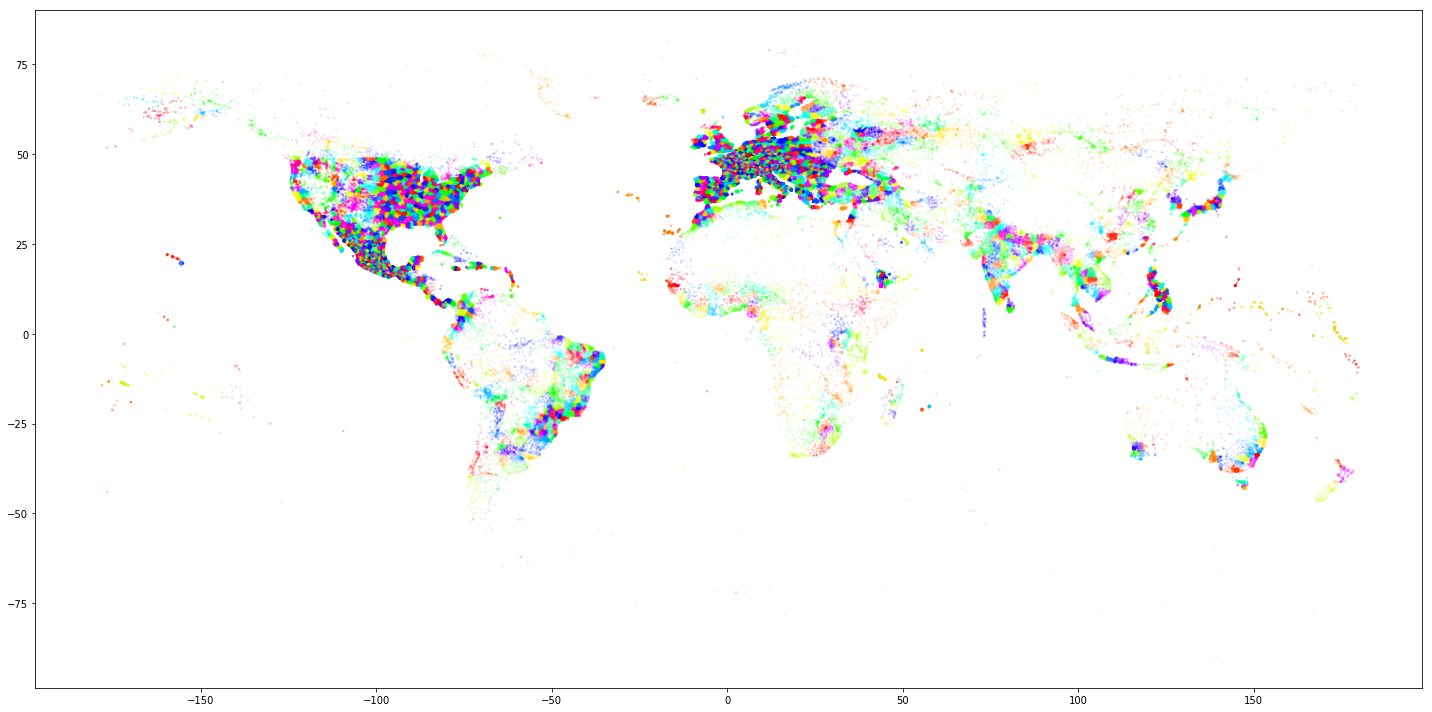

In [12]:
# Show clustering
plt.subplots(figsize=(20, 10))
plt.scatter(*df_large[COLUMNS_2D].values.T, alpha=.1, s=2, c=df_large[COLUMN_MINI_CLUSTER], cmap='hsv')
plt.tight_layout()

In [13]:
# Use spatial information only
data = df.loc[:, COLUMNS_3D].values
n, d = data.shape
n_large = df_large.shape[0]
n, n_large

(2048, 533132)

Transfer labels from clusters centers to their members

In [14]:
# Converting the WGS84 3D coordinates to latitude, longitude pairs is quite hard.
# Instead we will transfer the labels from the small clusters' center to all its 
# members for which we know the latitude/longitude.
# To this end, the following sparse matrix is used.
n_large = df_large.shape[0]
data_coo = numpy.ones(shape=(n_large,))
i_coo = numpy.arange(n_large)
j_coo = df_large[COLUMN_MINI_CLUSTER].values
transfer_coo = sparse.coo_matrix((data_coo, (i_coo, j_coo)), dtype=numpy.int32)
transfer_csr = transfer_coo.tocsr()

In [15]:
scaler = StandardScaler()

In [16]:
# Number of clusters to try
ks = [2, 3, 5, 8, 13, 21]

### General Remark
We show the result in the longitude-latitude plot. Observe that the clustering is performed on the actual 3D coordinates.

## k-Means

Apply the $k$-Means algorithm and experiment with the parameters. What do you observe in particular regarding runtime, and resulting clustering?

In [17]:
y_kmeans = benchmark_algorithm(
    alg=KMeans,
    params=[
        {
            'n_clusters': k,
        }
        for k in ks
    ],
)

{'n_clusters': 2}
CPU times: user 30.6 ms, sys: 0 ns, total: 30.6 ms
Wall time: 28.3 ms
{'n_clusters': 3}
CPU times: user 34.5 ms, sys: 0 ns, total: 34.5 ms
Wall time: 34.1 ms
{'n_clusters': 5}
CPU times: user 43.5 ms, sys: 0 ns, total: 43.5 ms
Wall time: 43 ms
{'n_clusters': 8}
CPU times: user 66.4 ms, sys: 0 ns, total: 66.4 ms
Wall time: 66.1 ms
{'n_clusters': 13}
CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 128 ms
{'n_clusters': 21}
CPU times: user 162 ms, sys: 0 ns, total: 162 ms
Wall time: 162 ms


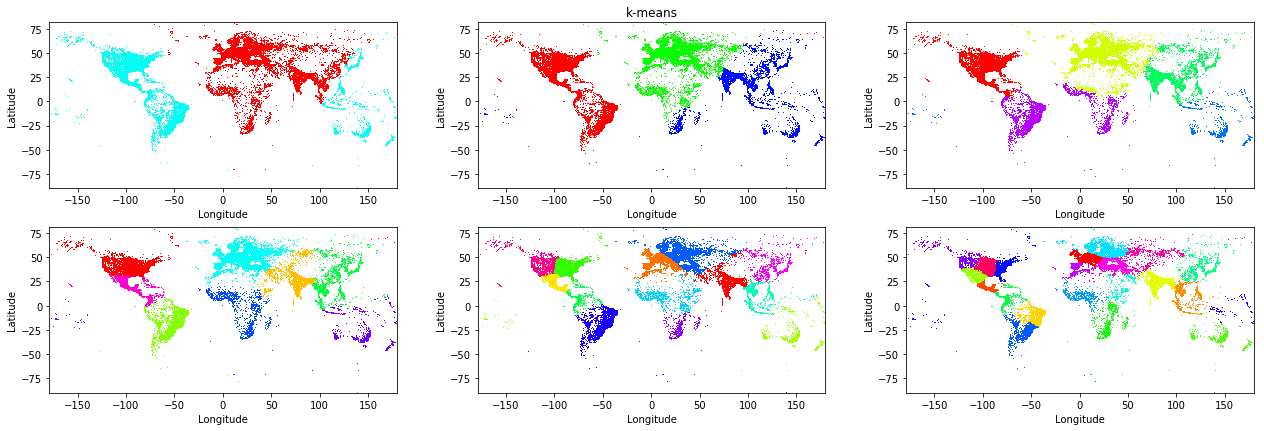

In [18]:
show_clusterings(df=df_large, y=y_kmeans, transfer_csr=transfer_csr, title='k-means')

### Observations

* Clusters = Voronoi-cells
* Clusters are approximately equally-sized
* Note: Clusters live in 3d space and the plots are projected
    * Clusters may wrap over dateline and thus appear non-contiguous
    * Clusters might appear non-convex
* No degenerate clusterings: Uses kmeans++ initialization with multiple independent runs -> relatively easy to avoid in practice
* Computation time grows with increasing k

## EM

Apply the EM algorithm and experiment with the parameters. What do you observe in particular regarding runtime, and resulting clustering?

{'n_components': 2, 'covariance_type': 'full', 'n_init': 10}
CPU times: user 196 ms, sys: 3 ms, total: 199 ms
Wall time: 198 ms
{'n_components': 3, 'covariance_type': 'full', 'n_init': 10}
CPU times: user 209 ms, sys: 0 ns, total: 209 ms
Wall time: 209 ms
{'n_components': 5, 'covariance_type': 'full', 'n_init': 10}
CPU times: user 482 ms, sys: 0 ns, total: 482 ms
Wall time: 481 ms
{'n_components': 8, 'covariance_type': 'full', 'n_init': 10}
CPU times: user 628 ms, sys: 0 ns, total: 628 ms
Wall time: 627 ms
{'n_components': 13, 'covariance_type': 'full', 'n_init': 10}
CPU times: user 989 ms, sys: 0 ns, total: 989 ms
Wall time: 988 ms
{'n_components': 21, 'covariance_type': 'full', 'n_init': 10}
CPU times: user 1.75 s, sys: 0 ns, total: 1.75 s
Wall time: 1.75 s
{'n_components': 2, 'covariance_type': 'spherical', 'n_init': 10}
CPU times: user 86 ms, sys: 0 ns, total: 86 ms
Wall time: 85.8 ms
{'n_components': 3, 'covariance_type': 'spherical', 'n_init': 10}
CPU times: user 94 ms, sys: 0 ns

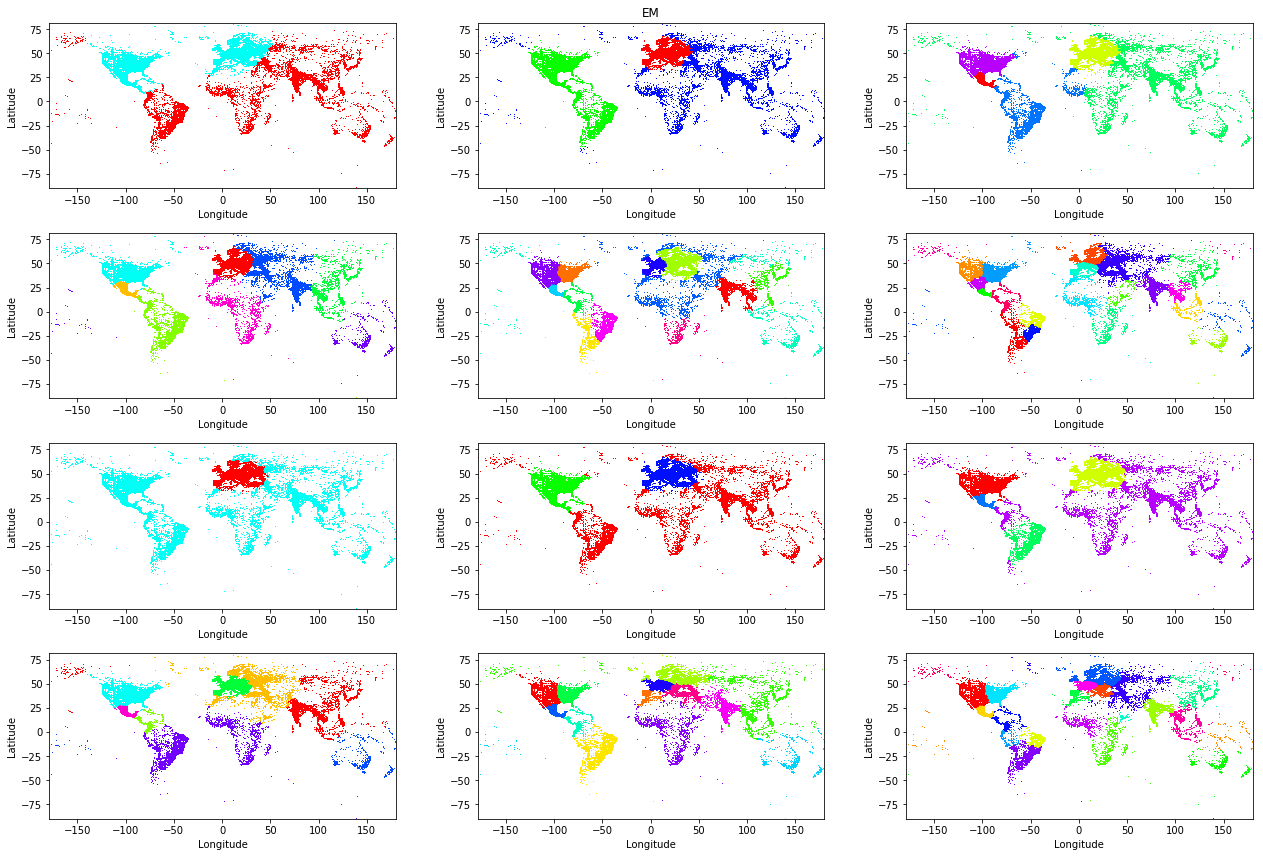

In [19]:
y_em = benchmark_algorithm(
    alg=GaussianMixture,
    params=[
        {
            'n_components': k,
            'covariance_type': cov,
            'n_init': 10,
        }
        for cov in ['full', 'spherical'] for k in ks
    ]
)
show_clusterings(df=df_large, y=y_em, title='EM', transfer_csr=transfer_csr)

### Observations

* Clusters appear blob-like
* Note clusters are 3-dim. arbitrarily oriented ellipsoids and might cut through the earth sphere
    * Clusters may be contained within other clusters
* Cluster sizes may differ considerably
* Often models Europe as a cluster since it is very dense
    * K-means is not able to "cut out" Europe since it cannot adapt cluster size
* Full vs. spherical covariance: Difference cannot be seen here clearly.
* Computation time grows with increasing k
* Full covariance matrix estimation requires more computation than spherical covariance.

## Spectral Clustering

Apply spectral clustering and experiment with the parameters. What do you observe in particular regarding runtime, and resulting clustering?

{'n_clusters': 2, 'affinity': 'nearest_neighbors', 'n_neighbors': 7, 'n_jobs': -1}
CPU times: user 2.51 s, sys: 4.44 s, total: 6.95 s
Wall time: 1.03 s
{'n_clusters': 3, 'affinity': 'nearest_neighbors', 'n_neighbors': 7, 'n_jobs': -1}
CPU times: user 2.03 s, sys: 4.18 s, total: 6.21 s
Wall time: 866 ms
{'n_clusters': 5, 'affinity': 'nearest_neighbors', 'n_neighbors': 7, 'n_jobs': -1}
CPU times: user 2.08 s, sys: 3.8 s, total: 5.88 s
Wall time: 844 ms
{'n_clusters': 8, 'affinity': 'nearest_neighbors', 'n_neighbors': 7, 'n_jobs': -1}
CPU times: user 1.75 s, sys: 3.38 s, total: 5.14 s
Wall time: 708 ms
{'n_clusters': 13, 'affinity': 'nearest_neighbors', 'n_neighbors': 7, 'n_jobs': -1}
CPU times: user 1.97 s, sys: 3.17 s, total: 5.14 s
Wall time: 712 ms
{'n_clusters': 21, 'affinity': 'nearest_neighbors', 'n_neighbors': 7, 'n_jobs': -1}
CPU times: user 2.11 s, sys: 4.06 s, total: 6.17 s
Wall time: 869 ms
{'n_clusters': 2, 'affinity': 'nearest_neighbors', 'n_neighbors': 50, 'n_jobs': -1}
CPU

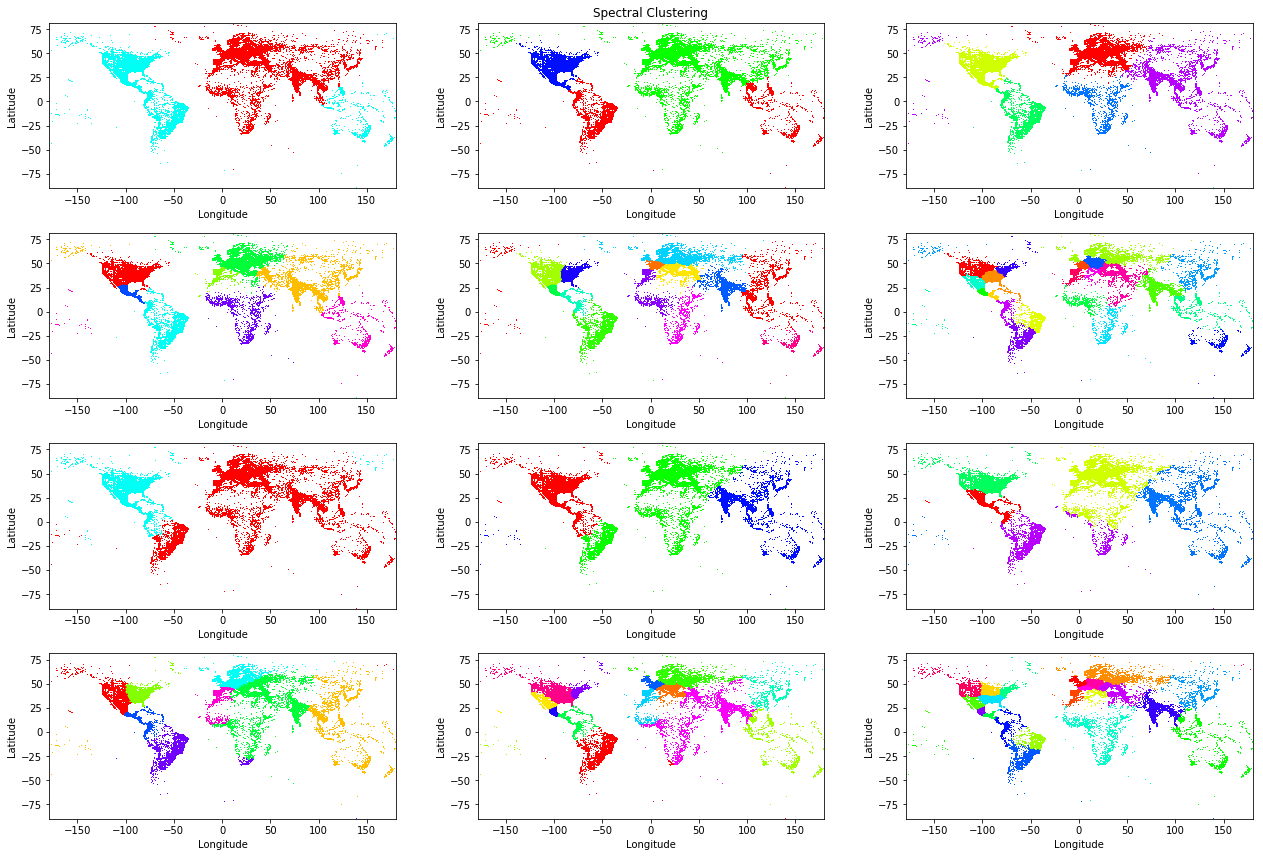

In [20]:
y_spectral = benchmark_algorithm(
    alg=SpectralClustering,
    params=[
        {
            'n_clusters': k,
            'affinity': 'nearest_neighbors',
            'n_neighbors': nn,
            'n_jobs': -1,
        }
        for nn in [7, 50] for k in ks
    ]
)
show_clusterings(df=df_large, y=y_spectral, title='Spectral Clustering', transfer_csr=transfer_csr)

### Observations

* Clusters can be arbitrarly shaped and are not restricted to be blob-like
* With a large number of neighbors, some clusters appear to be unintuitive, e.g. a small part of South Africa is often clustered together with South America. This is caused by the fact that the clustering is actually performed on the micro-clusters and the labels are then propagated to single points.

## Agglomerative Clustering

Apply agglomerative clustering and experiment with the parameters. What do you observe in particular regarding runtime, and resulting clustering?

{'n_clusters': 2, 'affinity': 'euclidean', 'linkage': 'single'}
CPU times: user 38 ms, sys: 6.56 ms, total: 44.5 ms
Wall time: 42.3 ms
{'n_clusters': 3, 'affinity': 'euclidean', 'linkage': 'single'}
CPU times: user 39.4 ms, sys: 0 ns, total: 39.4 ms
Wall time: 39.2 ms
{'n_clusters': 5, 'affinity': 'euclidean', 'linkage': 'single'}
CPU times: user 37.3 ms, sys: 578 µs, total: 37.8 ms
Wall time: 37.5 ms
{'n_clusters': 8, 'affinity': 'euclidean', 'linkage': 'single'}
CPU times: user 32.6 ms, sys: 4.27 ms, total: 36.9 ms
Wall time: 36.5 ms
{'n_clusters': 13, 'affinity': 'euclidean', 'linkage': 'single'}
CPU times: user 36.3 ms, sys: 0 ns, total: 36.3 ms
Wall time: 36.3 ms
{'n_clusters': 21, 'affinity': 'euclidean', 'linkage': 'single'}
CPU times: user 42.5 ms, sys: 161 µs, total: 42.6 ms
Wall time: 41.8 ms
{'n_clusters': 2, 'affinity': 'euclidean', 'linkage': 'average'}
CPU times: user 75.5 ms, sys: 3.5 ms, total: 79 ms
Wall time: 78.4 ms
{'n_clusters': 3, 'affinity': 'euclidean', 'linkage

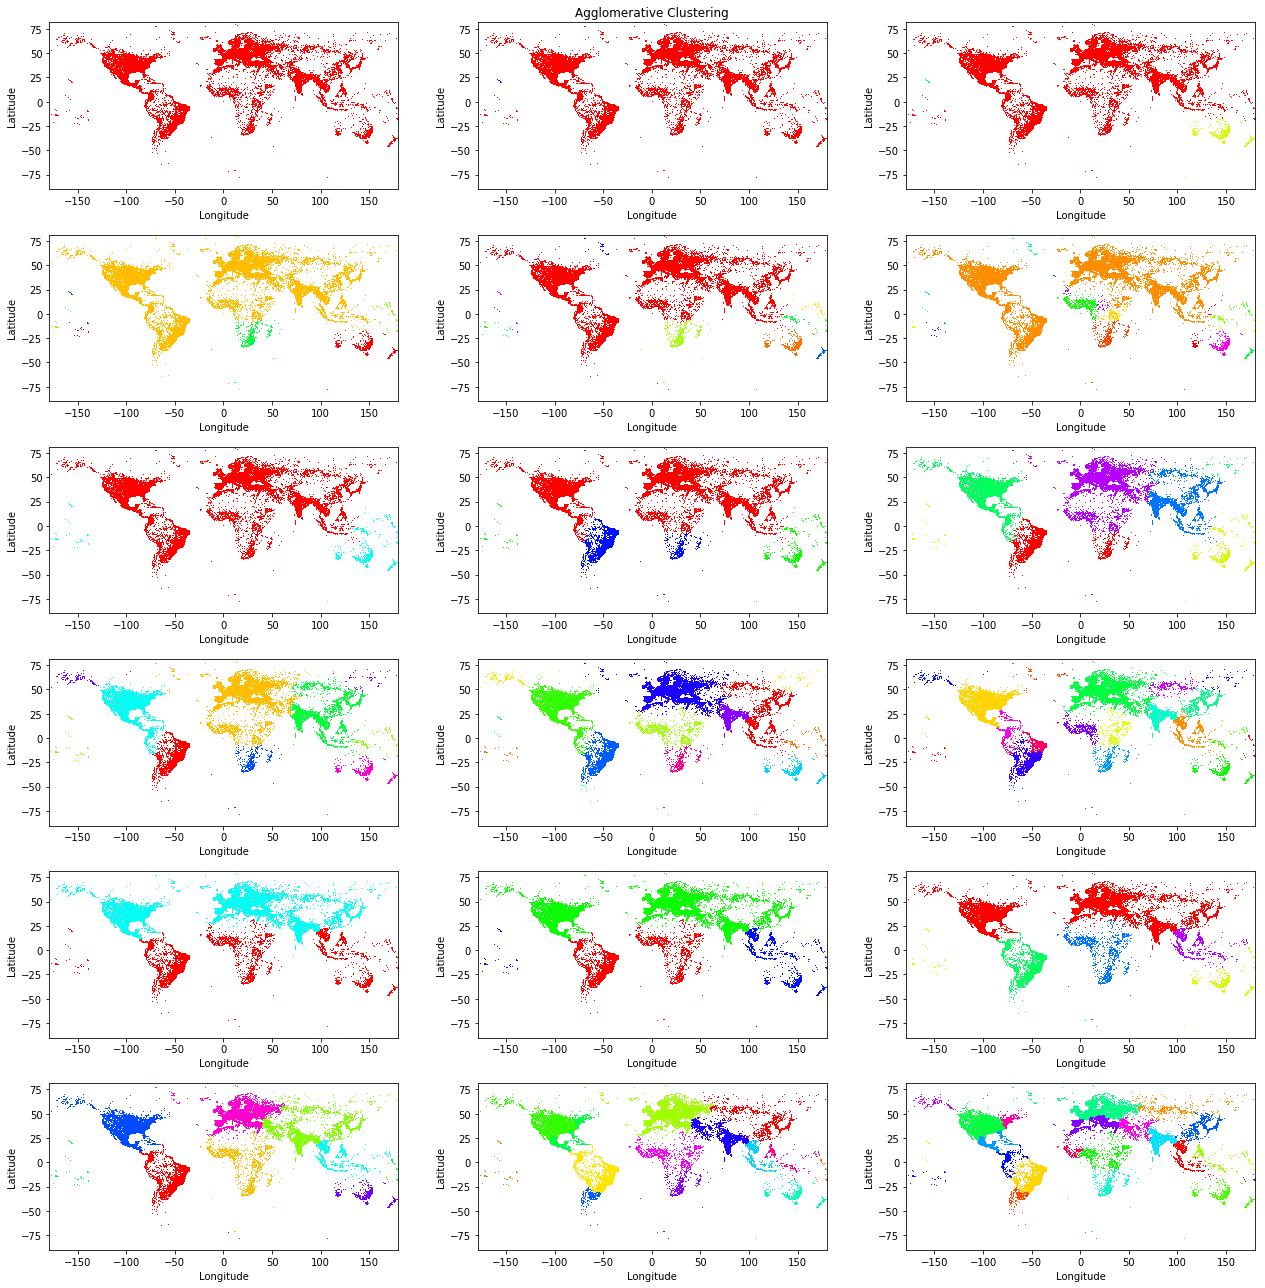

In [21]:
y_agglomerative = benchmark_algorithm(
    alg=AgglomerativeClustering,
    params=[
        {
            'n_clusters': k,
            'affinity': 'euclidean',
            'linkage': linkage,
        }
        for linkage in ['single', 'average', 'complete'] for k in ks
    ]
)
show_clusterings(df=df_large, y=y_agglomerative, title='Agglomerative Clustering', transfer_csr=transfer_csr)

### Observations

* As the clusterings for differnt k are extracted by cuts in the same dendrogram, the last image in group shows an intermediate step to first image
* Single-link produces one large and some very small clusters
* Average linkage produces more evenly-sized clusters
* Clusters found with complete linkage are more evenly-sized and compact


## DBSCAN

Apply DBSCAN and experiment with the parameters. What do you observe in particular regarding runtime, and resulting clustering?

{'eps': 250, 'metric': 'euclidean', 'min_samples': 2, 'algorithm': 'ball_tree', 'n_jobs': -1}
CPU times: user 37.6 ms, sys: 2.4 ms, total: 40 ms
Wall time: 108 ms
{'eps': 500, 'metric': 'euclidean', 'min_samples': 2, 'algorithm': 'ball_tree', 'n_jobs': -1}
CPU times: user 61.9 ms, sys: 7.4 ms, total: 69.3 ms
Wall time: 111 ms
{'eps': 1000, 'metric': 'euclidean', 'min_samples': 2, 'algorithm': 'ball_tree', 'n_jobs': -1}
CPU times: user 58.2 ms, sys: 0 ns, total: 58.2 ms
Wall time: 109 ms
{'eps': 250, 'metric': 'euclidean', 'min_samples': 5, 'algorithm': 'ball_tree', 'n_jobs': -1}
CPU times: user 48.6 ms, sys: 8.34 ms, total: 56.9 ms
Wall time: 109 ms
{'eps': 500, 'metric': 'euclidean', 'min_samples': 5, 'algorithm': 'ball_tree', 'n_jobs': -1}
CPU times: user 51 ms, sys: 5.69 ms, total: 56.7 ms
Wall time: 108 ms
{'eps': 1000, 'metric': 'euclidean', 'min_samples': 5, 'algorithm': 'ball_tree', 'n_jobs': -1}
CPU times: user 75 ms, sys: 1.56 ms, total: 76.6 ms
Wall time: 110 ms
{'eps': 250, 

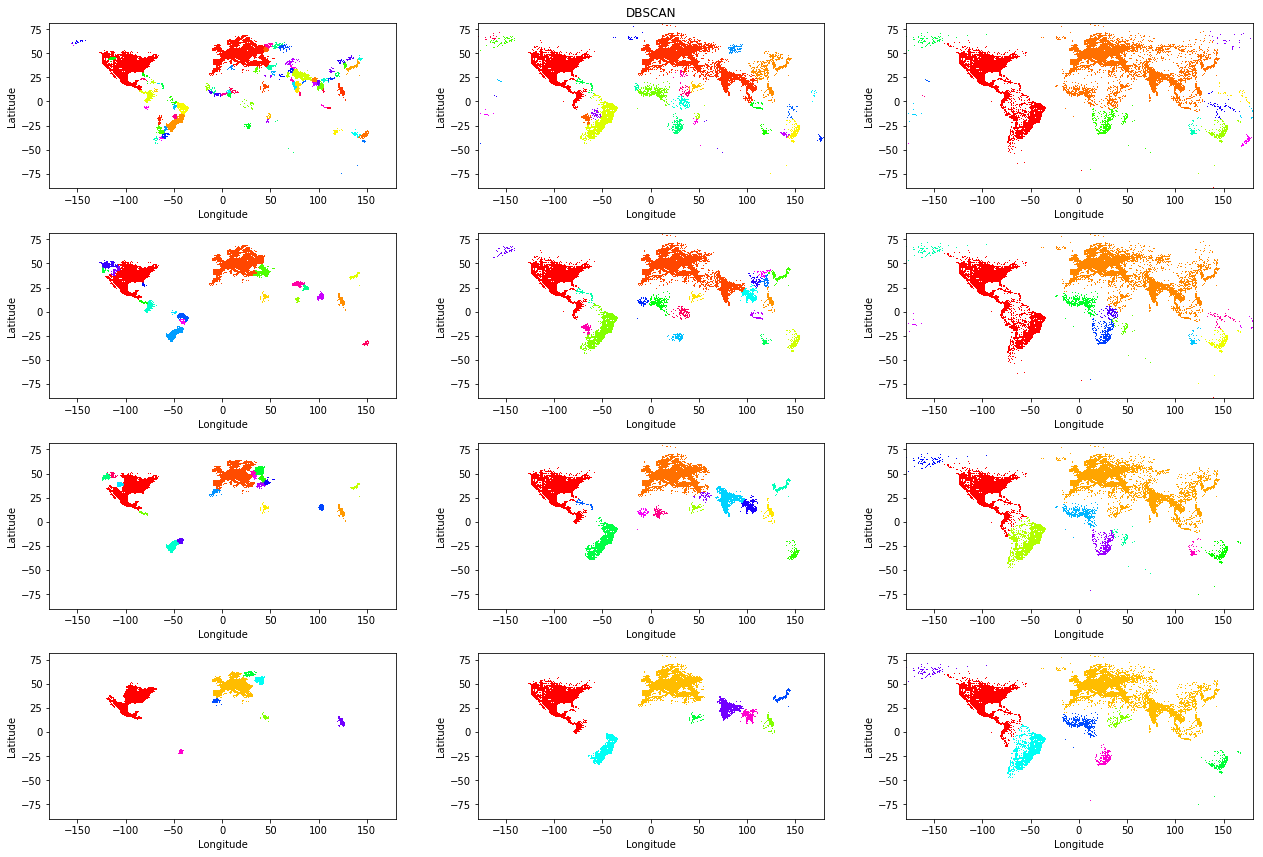

In [22]:
y_dbscan = benchmark_algorithm(
    alg=DBSCAN,
    params=[
        {
            'eps': eps,
            'metric': 'euclidean',
            'min_samples': min_samples,
            'algorithm': 'ball_tree',
            'n_jobs': -1,
        }
        for min_samples in [2, 5, 7, 10] for eps in [250, 500, 1000]
    ],
    scaling=False,
)
show_clusterings(df=df_large, y=y_dbscan, title='DBSCAN', transfer_csr=transfer_csr)

### Observations

* DBSCAN discards some points as noise, sometimes a lot of points are classified as noise
* Cluster shapes are arbitrary and not neccessarily blob-like
* Larger eps leads to fewer clusters
* Larger min_samples leads to more noise

## OPTICS

Apply OPTICS and experiment with the parameters. What do you observe in particular regarding runtime, and resulting clustering?

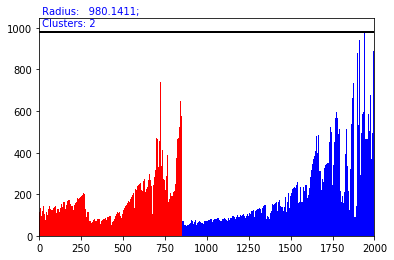

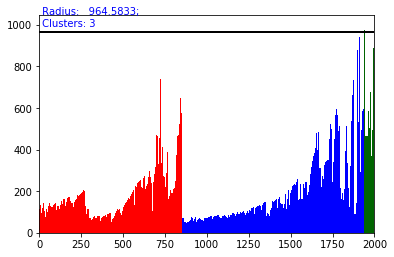

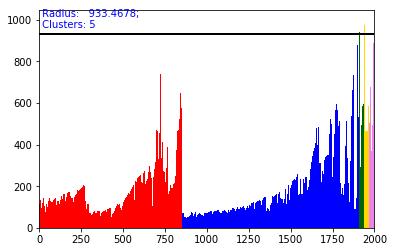

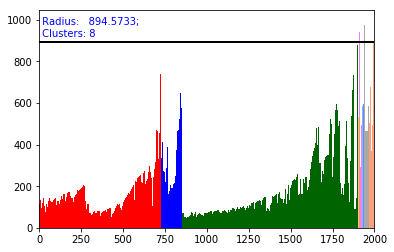

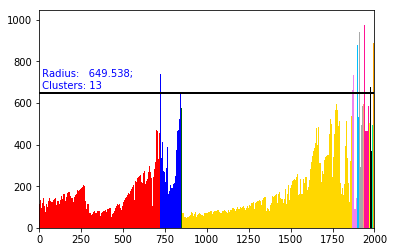

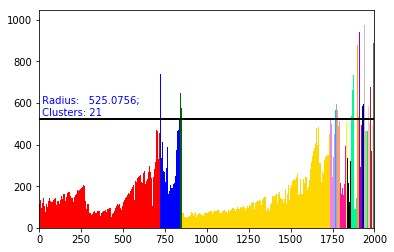

In [23]:
opt = optics.optics(
    data,
    eps=1000, 
    minpts=5, 
)
for j, k in enumerate(ks):
    # Show reachability plot
    opt.process()
    ordering = opt.get_ordering()
    analyzer = optics.ordering_analyser(ordering)
    optics.ordering_visualizer.show_ordering_diagram(analyzer, amount_clusters=k)

### Observations

* We can observe a clear cluster structure
    * Valleys correspond do densely connected reagions
    * Peaks correspond to gaps between regions
* If we want more clusters, we need to cut the reachability plot with a smaller eps
* We get a lot of smaller clusters on the right hand side of the diagram

## Mean Shift

Apply mean shift and experiment with the parameters. What do you observe in particular regarding runtime, and resulting clustering?

{'bandwidth': None, 'bin_seeding': False, 'n_jobs': -1}
CPU times: user 830 ms, sys: 214 ms, total: 1.04 s
Wall time: 3.11 s
{'bandwidth': 0.2, 'bin_seeding': False, 'n_jobs': -1}
CPU times: user 979 ms, sys: 296 ms, total: 1.28 s
Wall time: 16.2 s
{'bandwidth': 0.5, 'bin_seeding': False, 'n_jobs': -1}
CPU times: user 564 ms, sys: 107 ms, total: 671 ms
Wall time: 4.53 s
{'bandwidth': 1.0, 'bin_seeding': False, 'n_jobs': -1}
CPU times: user 347 ms, sys: 34.4 ms, total: 381 ms
Wall time: 2.08 s
{'bandwidth': 1.5, 'bin_seeding': False, 'n_jobs': -1}
CPU times: user 328 ms, sys: 26.4 ms, total: 354 ms
Wall time: 1.1 s
{'bandwidth': 2.0, 'bin_seeding': False, 'n_jobs': -1}
CPU times: user 373 ms, sys: 23.8 ms, total: 397 ms
Wall time: 1.52 s
{'bandwidth': None, 'bin_seeding': True, 'n_jobs': -1}
CPU times: user 549 ms, sys: 24.4 ms, total: 573 ms
Wall time: 795 ms
{'bandwidth': 0.2, 'bin_seeding': True, 'n_jobs': -1}
CPU times: user 713 ms, sys: 304 ms, total: 1.02 s
Wall time: 14.1 s
{'ban

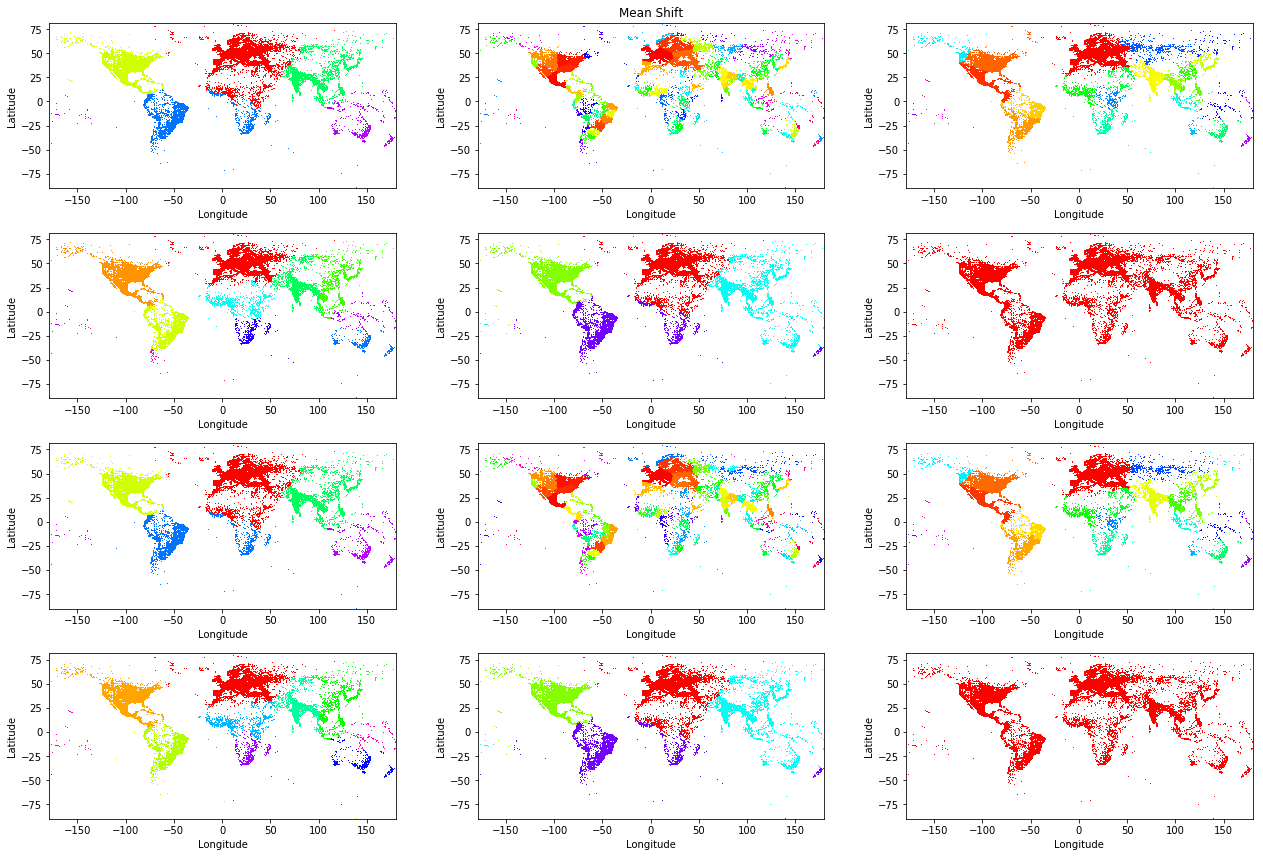

In [24]:
y_mean_shift = benchmark_algorithm(
    alg=MeanShift,
    params=[
        {
            'bandwidth': bandwidth,
            'bin_seeding': bin_seeding,
            'n_jobs': -1,
        }
        for bin_seeding in [False, True] for bandwidth in [None, 0.2, 0.5, 1.0, 1.5, 2.0]
    ],
)
show_clusterings(df=df_large, y=y_mean_shift, title='Mean Shift', transfer_csr=transfer_csr)

### Observations

* bin_seeding has a negligible effect on the results but is much faster
* Number of clusters decreases with increasing bandwidth
* Automatic bandwidth selection provides intuitively good clustering
    * Continents are recovered approximately
* Larger bandwidth decreases computation time.